This is a brief practice of convolutional neural network with tensorflow 2.0 high level API (tensorflow.keras). The example is based on ["Tensorflow in Practice Specialization"](https://www.coursera.org/specializations/tensorflow-in-practice)  from [deeplearning.ai](https://www.deeplearning.ai/).

Compared to tensorflow 1.0, tensorflow 2.0 provides a more comprehensive ecosystem of machine learning tools for developers (like what pytorch does), including the integration of the famous deep learning API "keras" which makes it easier and faster for users to implement deep learning instances and test new ideas. In this blog, we will build a complete deep learning implementation instance and as you will see, even within 30 minutes.

# 01: Prepare Data

## Download Data


In this example we will use a very famous "rock-paper-scissors" dataset with about 3000 images classified into 3 classes. Let's first download the training and validation datasets as zip files into the root path.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-08-09 13:22:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 209.85.145.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   126MB/s    in 1.5s    

2020-08-09 13:22:51 (126 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-08-09 13:22:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 173.194.194.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: 

Then unzip and extract the data. The training data will be located in the '/tmp/rps/' folder which has 3 sub-folders 'rock/', 'paper/' and 'scissor/'. The testing data will be located in the '/tmp/rps-test-set/' folder and the structure is the same as the training set.

In [2]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

Let's have a look at the training data, starting with listing the first 10 images of each classes.

In [3]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock03-003.png', 'rock01-008.png', 'rock07-k03-070.png', 'rock03-104.png', 'rock07-k03-093.png', 'rock02-005.png', 'rock02-077.png', 'rock07-k03-062.png', 'rock07-k03-014.png', 'rock07-k03-091.png']
['paper05-119.png', 'paper07-029.png', 'paper06-084.png', 'paper03-006.png', 'paper03-107.png', 'paper07-004.png', 'paper04-051.png', 'paper06-004.png', 'paper05-010.png', 'paper04-090.png']
['testscissors02-014.png', 'scissors01-109.png', 'scissors02-015.png', 'scissors02-021.png', 'testscissors02-005.png', 'scissors02-051.png', 'testscissors02-048.png', 'scissors02-110.png', 'scissors03-118.png', 'scissors03-049.png']


Then plot a few image examples. 

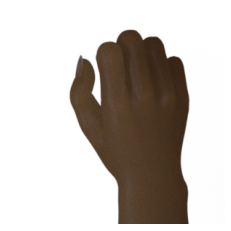

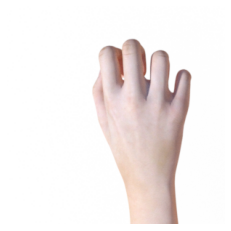

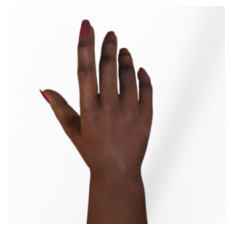

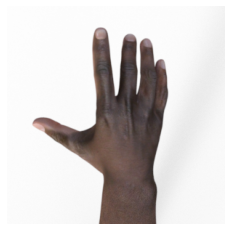

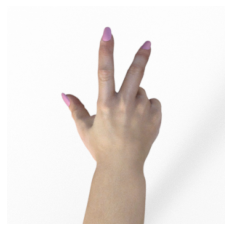

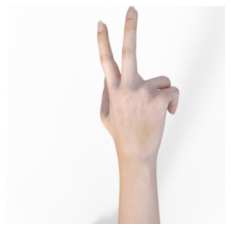

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

As you can see, the dataset includes different racies and some strange gestures (like 3 fingers which normally we see as a scissor), which would increase the diversity of the training data.

## Data Augmentation

Even though the training data has some kind of diversity, the amount is still too small for accurate usage and can easily meet the over-fitting problem. Therefore, we have to augment the training data to virtually increase the data size. Keras provides a convenient module for image preprocessing and using **ImageDataGenerator** we can conveniently increase the virtual data size without operating it on local disk.

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,        # limit the grey value to 0-1
	    rotation_range=40,       # the image can rotate from 0-40 degree
      width_shift_range=0.2,   #
      height_shift_range=0.2,  # the image can shift
      shear_range=0.2,         # the image can shear
      zoom_range=0.2,          # the image can zoom in and out to at most 20 percent
      horizontal_flip=True,    # the image can flip horizontally
      fill_mode='nearest')     # fill blank pixels after processing

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255) # only augment training dataset

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical', # multi-class mode, if two-class use 'binary'
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


# 02: Build Model

Tensorflow provides many APIs for building deep neural network models from low to high level. Here we use the most simple high-level API to quickly build a convolutional neural network. Check the network structure with **model.summary()**.

In [6]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # output probability of 3 classes: paper, rock, scissors
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# 03: Training and Visualization

Now let's complie and train the model with the training and validation data flow. Using 'crossentropy' as loss function, 'rmsprop' as optimizer and run 25 epochs. 

In [7]:

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("rps.h5") # save the trained model with trained weights

Epoch 1/25
20/20 [==============================] - 145s 7s/step - loss: 1.2752 - accuracy: 0.3655 - val_loss: 1.0899 - val_accuracy: 0.4462
Epoch 2/25
20/20 [==============================] - 140s 7s/step - loss: 1.1908 - accuracy: 0.4337 - val_loss: 1.0633 - val_accuracy: 0.5054
Epoch 3/25
20/20 [==============================] - 141s 7s/step - loss: 0.9561 - accuracy: 0.5294 - val_loss: 0.5792 - val_accuracy: 0.9140
Epoch 4/25
20/20 [==============================] - 142s 7s/step - loss: 0.8738 - accuracy: 0.6008 - val_loss: 0.6465 - val_accuracy: 0.7957
Epoch 5/25
20/20 [==============================] - 143s 7s/step - loss: 0.7257 - accuracy: 0.6766 - val_loss: 0.7644 - val_accuracy: 0.6210
Epoch 6/25
20/20 [==============================] - 142s 7s/step - loss: 0.6928 - accuracy: 0.6905 - val_loss: 0.2828 - val_accuracy: 0.9839
Epoch 7/25
20/20 [==============================] - 141s 7s/step - loss: 0.5855 - accuracy: 0.7694 - val_loss: 0.2311 - val_accuracy: 1.0000
Epoch 8/25
20

Let's have a look at the training process, watching how accuracy and loss change over epochs.

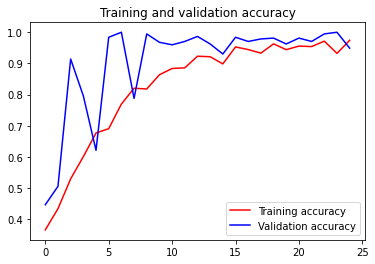

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

From the figure and output log we can see that after a few epochs both the training and validation dataset went up to a very high accuracy, which is very nice because we avoided the over-fitting thanks to data augmentation.

**Brainstorm: What would the accuracy figure look like if we have a serious over-fitting problem?** 

# 04: Use the model

Now the model is finished already. Let's take a photo of our own gesture have use the model to see if it's recognized correctly.

**Note: This bolck of codes needs a google colab module, please use google colab environment if you want to run the same codes. You can also use other GUI modules or just input the photo path for test.**

Saving paper.jpg to paper (3).jpg
Saving rock.jpg to rock (3).jpg
Saving scissor.jpg to scissor (3).jpg


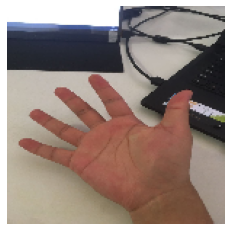

paper.jpg
[[1. 0. 0.]]


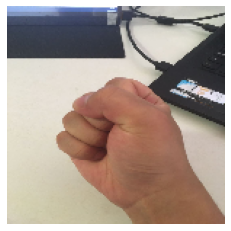

rock.jpg
[[0. 1. 0.]]


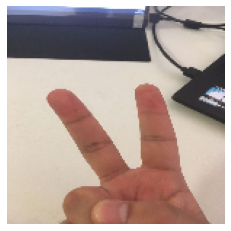

scissor.jpg
[[0. 1. 0.]]


In [17]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

We can see from the result that rock and paper are classified correctly. However, scissor is absolutedly wrong since the model shows 100% confindence that it is a rock. Is that because my fingers are short?:) Please feel free to test with your own hands.

# Summary

Congrats! You have finished one complete deep learning task with tensorflow. How many minutes do you take? Of course the training depends on the performance of your GPU, but the others should be quite easy to implement. However, the CNN model we used here is too simple, and maybe not enough for more complicated tasks. In the next blog, we'll have a look at **transfer learning** which is also very simple but can largely help us understand more comlex world.